In [1]:
%matplotlib notebook

import copy

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from mpl_toolkits.mplot3d import Axes3D

from classes.Settings import Settings
from helpers.plot_functions import plot_density, plot_fragment_colored, plot_vdw_spheres
from helpers.density_helpers import calculate_no_bins, add_boundaries_per_bin
from calc_avg_fragment_2 import read_results_alignment, make_avg_fragment_if_not_exists

from helpers.density_helpers import prepare_df, find_available_volume
from helpers.geometry_helpers import (make_coordinate_df,
                                      get_vdw_distance_contact)

from sklearn.cluster import KMeans

from tqdm import tqdm
import time
import math
import copy

In [2]:
resolutions = []

resolutions1 = np.arange(0.1, 1.1, 0.1)
resolutions.extend(resolutions1)

## Other stuff

In [3]:
def make_density_plot(avg_fragment, density_df, settings):
    plotname = settings.get_density_plotname()
    fig = plt.figure()
    ax: Axes3D = fig.add_subplot(111, projection='3d')

    ax = plot_fragment_colored(ax, avg_fragment)

    p, ax = plot_density(ax=ax, df=density_df, settings=settings)

    ax.set_title("4D density plot\n Resolution: " + str(settings.resolution))

    fig.colorbar(p)
    plt.savefig(plotname)
    plt.show()

In [4]:
settings = Settings(".\\results\\NO3\\NO3_XH_vdw.5\\NO3_XH_vdw.5_aligned.csv")
settings.set_atom_to_count("H")
settings.set_resolution(round(0.5, 2))

df = read_results_alignment(settings.get_aligned_csv_filename())
avg_fragment = make_avg_fragment_if_not_exists(settings, df)

density_df = pd.read_hdf(settings.get_density_df_filename(), settings.get_density_df_key())
make_density_plot(avg_fragment, density_df, settings)

<IPython.core.display.Javascript object>

In [5]:
def calc_clusters(density_df, amount_of_clusters):
    to_cluster_df = density_df[density_df['to_cluster']]
    
    X = np.transpose(np.array([to_cluster_df.x_center, to_cluster_df.y_center, to_cluster_df.z_center]))

    kmeans = KMeans(n_clusters=amount_of_clusters, random_state=1)
    kmeans.fit(X)
    
    density_df.loc[density_df['to_cluster'], "cluster"] = kmeans.labels_
    
    return density_df, kmeans.cluster_centers_

In [6]:
def make_cluster_plot(avg_fragment, df, column, settings, centroids):
    colors = ["red", "green", "blue"]
    
    df["cluster_color"] = "grey"

    df.loc[df[column].notna(), "cluster_color"] = [colors[int(i)] for i in list(df.loc[df[column].notna(), column])]
    df = df[df[settings.to_count_contact + "_normalized"] > 0]

    fig = plt.figure()
    ax: Axes3D = fig.add_subplot(111, projection='3d')

    ax = plot_fragment_colored(ax, avg_fragment)
    
    greys = df[df.cluster_color == "grey"]
    rest = df[df.cluster_color != "grey"]
    
    for i, centroid in enumerate(centroids):
        volume = len(df[df[column] == i]) * settings.resolution**3
        ax.scatter(centroid[0], centroid[1], centroid[2], s=100,\
                    label="Cluster: " + str(i+1), color=colors[i])
    
    ax.scatter(list(greys.x_center), list(greys.y_center), list(greys.z_center), s=0.1,
               color=list(greys.cluster_color), alpha=0.75)

    ax.scatter(list(rest.x_center), list(rest.y_center), list(rest.z_center),
               color=list(rest.cluster_color))

    ax.set_title("Clusters from density plot\n Resolution: " + str(settings.resolution))
    
    ax.set_xlim(-6, 6)
    ax.set_ylim(-6, 6)
    
    ax.set_xlabel("X coordinate")
    ax.set_ylabel("Y coordinate")
    
    ax.legend(fontsize='x-small')

    plt.show()

In [7]:
def find_bins_to_cluster(settings, fraction=0.25):
    
    density_df = pd.read_hdf(settings.get_density_df_filename(), settings.get_density_df_key())
    print(settings.get_density_df_filename(), settings.get_density_df_key())
    
    density_df["x_center"] = density_df.xstart + 0.5 * settings.resolution
    density_df["y_center"] = density_df.ystart + 0.5 * settings.resolution
    density_df["z_center"] = density_df.zstart + 0.5 * settings.resolution
    
    # normalize
    density_df.loc[:, settings.to_count_contact + "_normalized"] =\
        density_df[settings.to_count_contact] / density_df[settings.to_count_contact].sum()

    # reset cluster color for when you run this cell again
    density_df["cluster_color"] = np.nan
    
    # set a threshold as to determine will belong to a cluster and which ones won't
    # get the upper kwartant
    max_bin = density_df[settings.to_count_contact].max()
    threshold = max_bin * fraction
    print("Threshold k-means:", threshold, "max_bin:", max_bin, "with fraction:", fraction)
  
    density_df["cluster"] = np.nan
    density_df["to_cluster"] = False
    density_df.loc[density_df[settings.to_count_contact] > threshold, 'to_cluster'] = True
    
    return density_df

In [8]:
amount_of_clusters = 3

# set up cluster df to save all the clusters and their information in
cluster_df = pd.DataFrame(index=range(0, len(resolutions) * amount_of_clusters),\
                           columns=["resolution", "cluster_id", "centroid_x", "centroid_y", "centroid_z",\
                                    "cluster_volume", "datafraction"])

cluster_count = 0

for resolution in resolutions:
    print("RESOLUTION: ", round(resolution, 2))
    settings.set_resolution(round(resolution, 2))
    
    # work only with bins that are >0.25*maximum full
    density_df = find_bins_to_cluster(settings=settings, fraction=0.3)
        
    # calc for each bin in what cluster it belongs
    density_df, centroids = calc_clusters(density_df, amount_of_clusters)
        
    make_cluster_plot(avg_fragment, density_df, 'cluster', settings, centroids)
       
    for i, centroid in enumerate(centroids):
        df = density_df

        volume = len(df[df.cluster == i]) * (settings.resolution**3)
        data_fraction = df[df.cluster == i][settings.to_count_contact + "_normalized"].sum()
        
        # specific for NO3 - XH
        cluster_idx = 3
        
        if centroid[0] > 1.5:
            cluster_idx = 1
        elif centroid[1] < -0.5:
            cluster_idx = 2

        cluster_df.iloc[cluster_count] = [float(resolution), cluster_idx, centroid[0], centroid[1], centroid[2], volume, data_fraction]
        
        cluster_count +=1

RESOLUTION:  0.1
.\results\NO3\NO3_XH_vdw.5\NO3_XH_vdw.5_density.hdf H01
Threshold k-means: 7.8 max_bin: 26.0 with fraction: 0.3


<IPython.core.display.Javascript object>

RESOLUTION:  0.2
.\results\NO3\NO3_XH_vdw.5\NO3_XH_vdw.5_density.hdf H02
Threshold k-means: 31.2 max_bin: 104.0 with fraction: 0.3


<IPython.core.display.Javascript object>

RESOLUTION:  0.3
.\results\NO3\NO3_XH_vdw.5\NO3_XH_vdw.5_density.hdf H03
Threshold k-means: 84.6 max_bin: 282.0 with fraction: 0.3


<IPython.core.display.Javascript object>

RESOLUTION:  0.4
.\results\NO3\NO3_XH_vdw.5\NO3_XH_vdw.5_density.hdf H04
Threshold k-means: 151.79999999999998 max_bin: 506.0 with fraction: 0.3


<IPython.core.display.Javascript object>

RESOLUTION:  0.5
.\results\NO3\NO3_XH_vdw.5\NO3_XH_vdw.5_density.hdf H05
Threshold k-means: 211.2 max_bin: 704.0 with fraction: 0.3


<IPython.core.display.Javascript object>

RESOLUTION:  0.6
.\results\NO3\NO3_XH_vdw.5\NO3_XH_vdw.5_density.hdf H06
Threshold k-means: 256.8 max_bin: 856.0 with fraction: 0.3


<IPython.core.display.Javascript object>

RESOLUTION:  0.7
.\results\NO3\NO3_XH_vdw.5\NO3_XH_vdw.5_density.hdf H07
Threshold k-means: 469.79999999999995 max_bin: 1566.0 with fraction: 0.3


<IPython.core.display.Javascript object>

RESOLUTION:  0.8
.\results\NO3\NO3_XH_vdw.5\NO3_XH_vdw.5_density.hdf H08
Threshold k-means: 488.7 max_bin: 1629.0 with fraction: 0.3


<IPython.core.display.Javascript object>

RESOLUTION:  0.9
.\results\NO3\NO3_XH_vdw.5\NO3_XH_vdw.5_density.hdf H09
Threshold k-means: 680.1 max_bin: 2267.0 with fraction: 0.3


<IPython.core.display.Javascript object>

RESOLUTION:  1.0
.\results\NO3\NO3_XH_vdw.5\NO3_XH_vdw.5_density.hdf H1
Threshold k-means: 801.3 max_bin: 2671.0 with fraction: 0.3


<IPython.core.display.Javascript object>

In [9]:
display(cluster_df)

,resolution,cluster_id,centroid_x,centroid_y,centroid_z,cluster_volume,datafraction
0,0.1,2,-0.329595,-2.07424,0.369711,0.162,0.0248307
1,0.1,3,-0.210299,2.10527,0.339492,0.18,0.0282608
2,0.1,1,3.79849,0.386931,0.361372,0.124,0.0188505
3,0.2,2,-0.227897,-2.12546,0.38616,0.496,0.0423333
4,0.2,1,3.80502,0.138616,0.35,0.384,0.0331122
5,0.2,3,-0.176839,2.12002,0.375784,0.568,0.0500369
6,0.3,2,-0.134936,-2.14919,0.39,0.702,0.0466088
7,0.3,1,3.825,0.0211722,0.351136,0.594,0.0418059
8,0.3,3,-0.0962963,2.19327,0.358333,0.729,0.0517875
9,0.4,2,-0.110331,-2.1274,0.362807,1.216,0.0583927


In [10]:
clusters = [[], [], []]

fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(1, 1, 1)

plt.title("Centroid of the clusters for all resolutions")


colors = ["green", "tab:green", "fuchsia"]

for _, centroid in cluster_df.iterrows():
    ax.scatter(centroid.centroid_x, centroid.centroid_y, color=colors[int(centroid.cluster_id - 1)])
    

for _, row in avg_fragment.iterrows():
    if row.atom_symbol == "O":
        ax.scatter(row.atom_x, row.atom_y, edgecolor="black", color="red")
    else:
        ax.scatter(row.atom_x, row.atom_y, edgecolor="black", color="grey")

plt.xlim(-2, 5)
plt.ylim(-3, 4)
plt.show()

<IPython.core.display.Javascript object>

In [11]:
cluster_df = cluster_df.astype('float')
cluster_df["fraction_over_volume"] = cluster_df["datafraction"] / cluster_df["cluster_volume"]

In [12]:
plt.figure(figsize=(6,4))
plt.title("Cluster volume")
for i in range(amount_of_clusters):
    
    plt.plot(cluster_df[cluster_df["cluster_id"] == i + 1].resolution, 
             cluster_df[cluster_df["cluster_id"] == i + 1].cluster_volume, 
             label="Cluster " + str(i+1),
             color=colors[i -1])

plt.xlabel("Resolution")
plt.ylabel("Volume ($\AA^{3}$)")
plt.legend()
plt.show()

<IPython.core.display.Javascript object>

In [13]:
plt.figure(figsize=(6,4))
plt.title("Datfraction per cluster")
for i in range(amount_of_clusters):
    
    plt.plot(cluster_df[cluster_df["cluster_id"] == i + 1].resolution, 
             cluster_df[cluster_df["cluster_id"] == i + 1].datafraction,
             label="Cluster " + str(i+1),
             color=colors[i-1])

plt.legend()
plt.xlabel("Resolution")
plt.ylabel("Fraction")
plt.show()

<IPython.core.display.Javascript object>

In [14]:
plt.figure(figsize=(5,4))
plt.title("Fraction over volume")
for i in range(amount_of_clusters):
    
    plt.plot(cluster_df[cluster_df["cluster_id"] == i + 1].resolution, 
             cluster_df[cluster_df["cluster_id"] == i + 1].fraction_over_volume,
             label="Cluster " + str(i+1),
             color=colors[i-1])

plt.legend()
plt.xlabel("Resolution")
plt.ylabel("Fraction over volume ($\AA^{-3}$)")
plt.show()

<IPython.core.display.Javascript object>

# General: make function for Directionality Calculation

In [15]:
def recluster(df, settings, recluster_frac):
    amount = settings.to_count_contact
    
    unique_clusters = df.cluster.dropna().unique()

    df["new_cluster"] = np.nan
    
    fullest_bin = []
    for cluster_id in unique_clusters:
        
        max_bin = df[df.cluster == cluster_id][amount].max()
        
        # add old bins that are full enough when using local maximum
        fraction = max_bin * recluster_frac
        print("Cluster id: " + str(cluster_id), " max bin: " + str(max_bin) + " fraction for this bin: ", fraction)
        df.loc[((df.cluster == cluster_id) & (df[amount] > fraction)), 'new_cluster'] = cluster_id      
            
        # add bins in "x" radius around the local maximums
        new_found = True
        
        # search 1 bins further in all directions
        radius = settings.resolution
        
        # while new bins that belong to the cluster are found, keep expanding
        while new_found:
            old_length = len(df[df.new_cluster == cluster_id])
            
            for _, row in df[df.new_cluster == cluster_id].iterrows():
                df.loc[(df.x_center > row.x_center - radius) & (df.x_center < row.x_center + radius) & 
                    (df.y_center > row.y_center - radius) & (df.y_center < row.y_center + radius) &
                    (df.z_center > row.z_center - radius) & (df.z_center < row.z_center + radius) &
                    (df[amount] > fraction) & (df.new_cluster.isna()), 'new_cluster'] = cluster_id
                
            new_length = len(df[df.new_cluster == cluster_id])
            
            if new_length <= old_length:
                new_found = False
        
    return df

In [16]:
def calc_directionality(central, contact, to_count_contact, resolution, k, kmeans_frac, recluster_frac):
    settings = Settings(".\\results\\NO3\\NO3_XH_vdw.5\\NO3_XH_vdw.5_aligned.csv")
    settings.set_atom_to_count(to_count_contact)
    settings.set_resolution(round(0.2, 2))

    amount_of_clusters = 3

    cluster_count = 0

    # work only with bins that are >0.25*maximum full
    density_df = find_bins_to_cluster(settings=settings, fraction=0.25)

    # calc for each bin in what cluster it belongs
    density_df, _ = calc_clusters(density_df, amount_of_clusters)
    density_df.drop(columns=["to_cluster"])
    
    # find the volume of the central group
    tolerance = 0.5

    df = read_results_alignment(settings.get_aligned_csv_filename())
    avg_fragment = make_avg_fragment_if_not_exists(settings, df)

    coordinate_df = make_coordinate_df(df, settings, avg_fragment)

    contact_radius = get_vdw_distance_contact(coordinate_df, settings)

    available_volume = find_available_volume(avg_fragment=avg_fragment, extra=(tolerance + contact_radius))
    
    print("\nRecluster")
    density_df = recluster(density_df, settings, recluster_frac)
        
    return density_df, available_volume

In [17]:
density_df, V_available = calc_directionality(central="NO3",
                                              contact="XH",
                                              to_count_contact="H",
                                              resolution=0.2, 
                                              k=3, 
                                              kmeans_frac=0.25,
                                              recluster_frac=0.25)

display(density_df)
print("Available volume:", V_available)

.\results\NO3\NO3_XH_vdw.5\NO3_XH_vdw.5_density.hdf H02
Threshold k-means: 26.0 max_bin: 104.0 with fraction: 0.25

Recluster
Cluster id: 0.0  max bin: 93.0 fraction for this bin:  23.25
Cluster id: 1.0  max bin: 102.0 fraction for this bin:  25.5
Cluster id: 2.0  max bin: 104.0 fraction for this bin:  26.0


,xstart,ystart,zstart,H,x_center,y_center,z_center,H_normalized,cluster_color,cluster,to_cluster,new_cluster
0,-4.200000,-5.400000,-1.000000,0.0,-4.100000,-5.300000,-0.900000,0.0,NaN,NaN,False,NaN
1,-4.200000,-5.400000,-0.806452,0.0,-4.100000,-5.300000,-0.706452,0.0,NaN,NaN,False,NaN
2,-4.200000,-5.400000,-0.612903,0.0,-4.100000,-5.300000,-0.512903,0.0,NaN,NaN,False,NaN
3,-4.200000,-5.400000,-0.419355,0.0,-4.100000,-5.300000,-0.319355,0.0,NaN,NaN,False,NaN
4,-4.200000,-5.400000,-0.225806,0.0,-4.100000,-5.300000,-0.125806,0.0,NaN,NaN,False,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
93739,6.203704,5.403572,4.032258,0.0,6.303704,5.503572,4.132258,0.0,NaN,NaN,False,NaN
93740,6.203704,5.403572,4.225806,0.0,6.303704,5.503572,4.325806,0.0,NaN,NaN,False,NaN
93741,6.203704,5.403572,4.419355,0.0,6.303704,5.503572,4.519355,0.0,NaN,NaN,False,NaN
93742,6.203704,5.403572,4.612903,0.0,6.303704,5.503572,4.712903,0.0,NaN,NaN,False,NaN


Available volume: 198.49300000000005


In [18]:
unique_clusters = density_df.cluster.dropna().unique()

In [32]:
print('Cluster ID, Volume, DataFraction Datafraction/Volume, Datafraction/Volume * available volume')
# print result for comparance
for cluster_id in unique_clusters:
    volume = len(density_df[density_df.cluster == cluster_id]) * (0.2**3)
    data_fraction = density_df[density_df.cluster == cluster_id][settings.to_count_contact + "_normalized"].sum()
    
    print(cluster_id +1,  round(volume,4), round(data_fraction,4), round(data_fraction/volume,4), round(data_fraction/volume * V_available,4))

print("\nReclustered")
for cluster_id in unique_clusters:
    volume = len(density_df[density_df.new_cluster == cluster_id]) * (0.2**3)
    data_fraction = density_df[density_df.new_cluster == cluster_id][settings.to_count_contact + "_normalized"].sum()
    
    print(cluster_id+1,  round(volume,4), round(data_fraction,4), round(data_fraction/volume,4), round(data_fraction/volume * V_available,4))

Cluster ID, Volume, DataFraction Datafraction/Volume, Datafraction/Volume * available volume
1.0 0.664 0.0509 0.0767 15.2257
2.0 0.704 0.0571 0.0812 16.1128
3.0 0.576 0.0431 0.0747 14.8373

Reclustered
1.0 0.776 0.0559 0.0721 14.3073
2.0 0.736 0.0587 0.0797 15.8177
3.0 0.576 0.0431 0.0747 14.8373


<IPython.core.display.Javascript object>


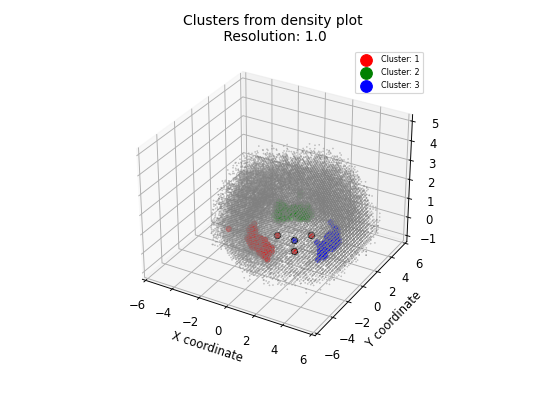

<IPython.core.display.Javascript object>


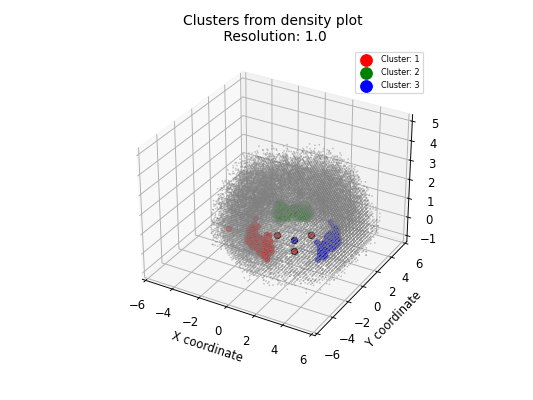

In [33]:
make_cluster_plot(avg_fragment, density_df, 'cluster', settings, centroids)
make_cluster_plot(avg_fragment, density_df, 'new_cluster', settings, centroids)

In [34]:
def show_directionality(avg_fragment, df, column, settings, available_volume):
    colors = ["red", "green", "blue"]
    
    df["cluster_color"] = "grey"

    df.loc[df[column].notna(), "cluster_color"] = [colors[int(i)] for i in list(df.loc[df[column].notna(), column])]
    df = df[df[settings.to_count_contact + "_normalized"] > 0]

    fig = plt.figure(figsize=(8,8))
    ax: Axes3D = fig.add_subplot(111, projection='3d')

    rest = df[df.cluster_color != "grey"]
    
    for cluster_id in df[column].dropna().unique():
        points = df[df[column] == cluster_id]
        firstpoint = points.iloc[0]
        volume = len(points) * settings.resolution**3
        fraction = points[settings.to_count_contact + "_normalized"].sum()
        directionality = fraction/volume * available_volume
        
        ax.scatter(firstpoint.x_center, firstpoint.y_center, firstpoint.z_center,\
                    label="Cluster: " + str(cluster_id) + " Directionality:" + str(round(directionality, 2)),\
                    color=firstpoint.cluster_color)
    
    ax.scatter(list(rest.x_center), list(rest.y_center), list(rest.z_center),
               color=list(rest.cluster_color))
    
    # plot the average fragment
    ax = plot_fragment_colored(ax, avg_fragment)

    ax.set_title("Clusters " + settings.central_group_name + "-" + settings.contact_group_name + ", resolution: " + str(settings.resolution))
    
    ax.set_xlim(-6, 6)
    ax.set_ylim(-6, 6)
    
    ax.set_xlabel("X coordinate")
    ax.set_ylabel("Y coordinate")
    
    ax.legend(fontsize='x-small')
    
    elev = 91
    azim = 89
    ax.view_init(elev, azim)

    plt.show()

<IPython.core.display.Javascript object>


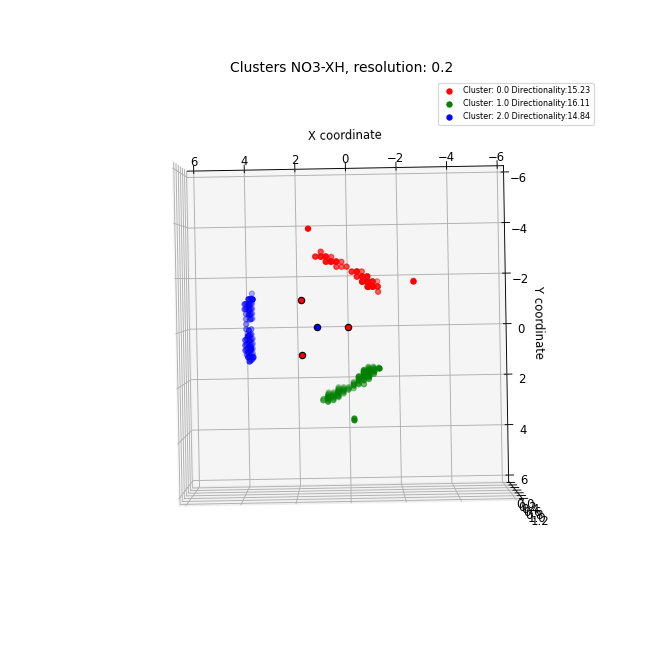

<IPython.core.display.Javascript object>


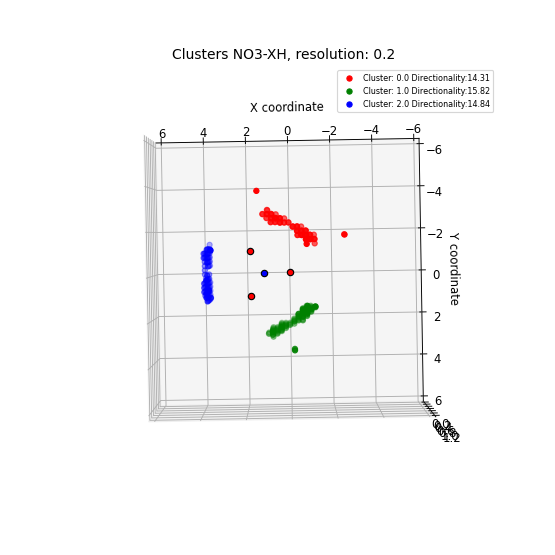

In [36]:
settings.set_resolution(0.2)

show_directionality(avg_fragment, density_df, 'cluster', settings, V_available)
show_directionality(avg_fragment, density_df, 'new_cluster', settings, V_available)

# Azimuth, elevation test

In [ ]:
# ****************************************************************************
# *                               Create data                                *
# ****************************************************************************
np.random.seed(11)
n = 200
x = y = np.linspace(-10, 10, n)
z = np.random.randn(n)*3 + 2


# ****************************************************************************
# *                                 Plot data                                *
# ****************************************************************************
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

# # If we knew what angles we wanted to set, these lines will set it


# Show the figure, adjust it with the mouse
plt.show()

# Once the figure is closed, the azimutal angle and the elevation will
# be printed. They may be used as input for ax.view_init(elev, azim)
print('ax.azim {}'.format(ax.azim))
print('ax.elev {}'.format(ax.elev))